# Gans Data Pipeline

## Introduction

Gans is a startup company developing an e-scooter sharing system. They plan on expanding to the most populous cities around the world. In each of these cities hundreds of e-scooters are parked in the streets and can be rented by its' users. In order to compete with already well established companies like TIER or Lime, the placement of the scooters is paramount. Gans can only be succesful, if the scooters are placed  where the users need them.
The goal of this project is to create a data pipeline that automatically gathers information which the company thinks is important in order to be succesful. The main focus lies on the following two aspects:

1. **Weather:** Since no one wants to ride a scooter when it is raining/snowing, we want to gather the weather data of the cities.

2. **Flights data:** The renting of scooters is popular especially among tourists. Therefore we gather flights data of nearby airports. 

In this project we limit ourselves to the biggest European cities.

### Technologies used

- Python: pandads, BeautifulSoup, requests, SQLalchemy
- SQL
- AWS: RDS, Lambda

## Gathering Static Data

### City Data

As we focus ourselves to European cities, the starting point of our data collection is the following Wikipedia page: 

https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits

As one can tell by the name it lists the 94 biggest cities by population in the European Union.
In a first step we collect the city name and the population of that city. Afterwards we visit each of the cities' own Wikipedia page to collect the its' some geographical information, namely the latitude and longitude. We need these numbers later to collect the data of nearby airports.
Finally we clean the data we gathered.

- To get information from the internet we use the Python libraries BeautifulSoup and requests:

In [1]:
from bs4 import BeautifulSoup
import requests

#get html code
doc_url = 'https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits'
response = requests.get(doc_url)
if response.status_code != 200:
    raise Exception(f'wikipedia returned code {response.status_code} for url = {doc_url}')
soup = BeautifulSoup(response.content, 'html.parser')

We now read the content of the page as an html-file. Let's look at the page:

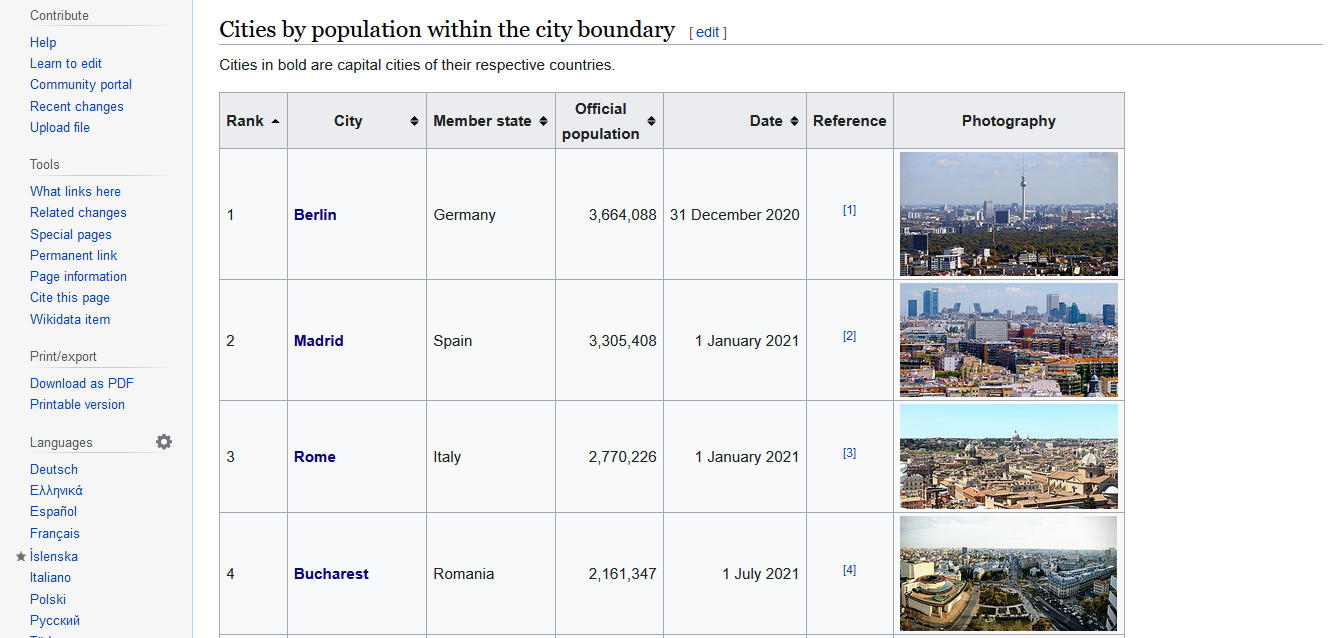

The information we want is contained in a table.
We can investigate the html-code of the page to know how we can extract the city names and population:

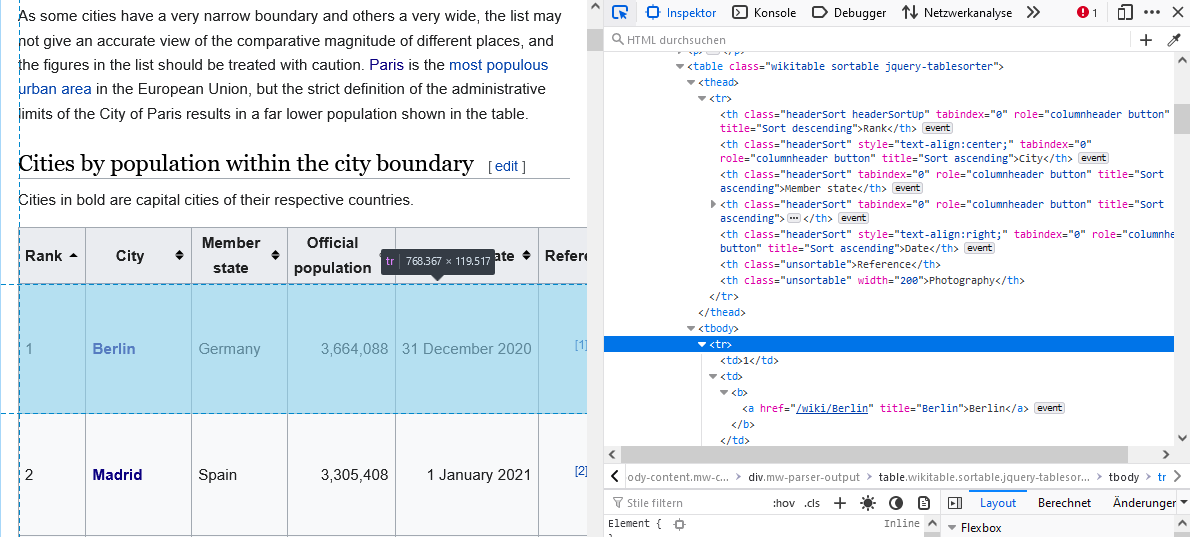

Following the html-structure on the right side, it seems that the information is stored in "table.wikitable > tbody > tr". Looking further into it, we can see that the city name is in a subsection "td". We can also see the link that sends us to the Wikipedia entry of the city. 

In [2]:
table = soup.select('table.wikitable > tbody > tr')

# prettify the names and take only selected ones
header = [h.text.strip().replace(' ', '_').lower() for h in table[0].select('th')][1:-2]
cities = [[cell.text.strip() for cell in city.select('td')[1:-2]] for city in table[1:]]
    
city_url = 'https://en.wikipedia.org'
links = [city_url + city.select('td:nth-child(2) a:first-of-type')[0]['href'] for city in table[1:]]

Fortunately the city pages are built quite consistent, so that extracting the latitude and longitude was quite easy:
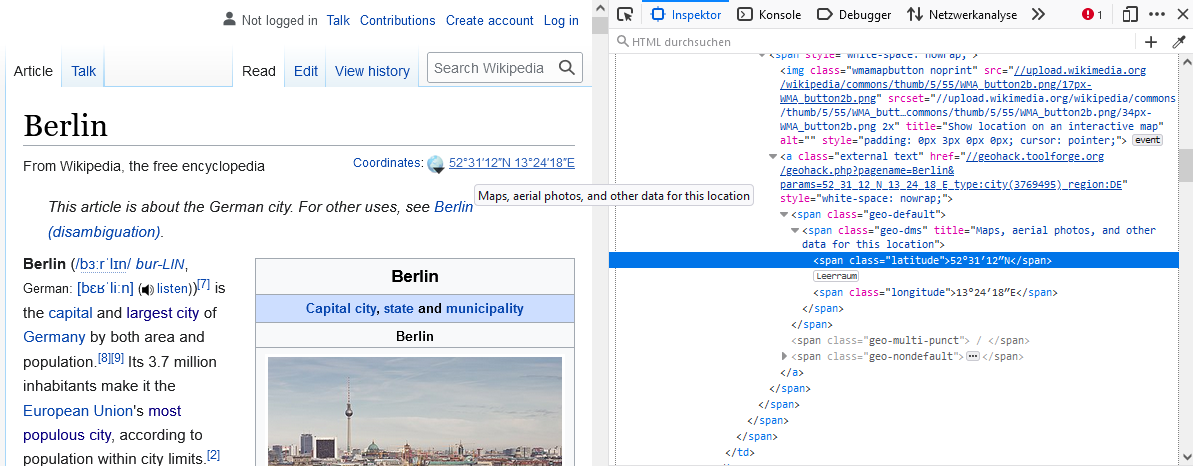

In [ ]:
latitude = []
longitude = []
for city_url in links:
    city_response = requests.get(city_url)
    soup = BeautifulSoup(city_response.content, "html.parser")
    latitude.append(soup.select(".latitude")[0].get_text())
    longitude.append(soup.select(".longitude")[0].get_text())

We want the latitude and longitude to be float numbers. Therefore we clean these entries:

In [ ]:
df.loc[:,'lat'] = df.lat.str.replace('\D','', regex=True)
df.loc[:,'lat'] = df.lat.str[:2] + '.' + df.lat.str[2:]

df.loc[:,'lon'] = df.lon.str.replace('.','')
df.loc[:,'lon'] = df.lon.str.replace('°','.')
mask = df.lon.str[-1] == 'W','lon'
df.loc[mask] = '-' + df.loc[mask]
df.loc[:,'lon'] = df.lon.replace('[EW]|″|′', '', regex=True)
df.loc[:,'lat'] = pd.to_numeric(df['lat'])
df.loc[:,'lon'] = pd.to_numeric(df['lon'])

Since all latitudes gathered are on the north half of the earth and not too close to the equator, we can just remove all non-digits and put a floating point after the second digit.
If we would look at cities all over the world, we should proceed as we do for the longitude. Note that latitudes in the south and longitudes in the west correspond to negative numbers.

Now we are ready to move on to the airports data.

## Airports data

To find nearby airports we make use of our lat/lon-values we gathered in the previous section. Also we'll use an API to make our life easier. Our best friend for this task is rapidapi.com, an API-hub containing thousands of APIs for many puposes! 
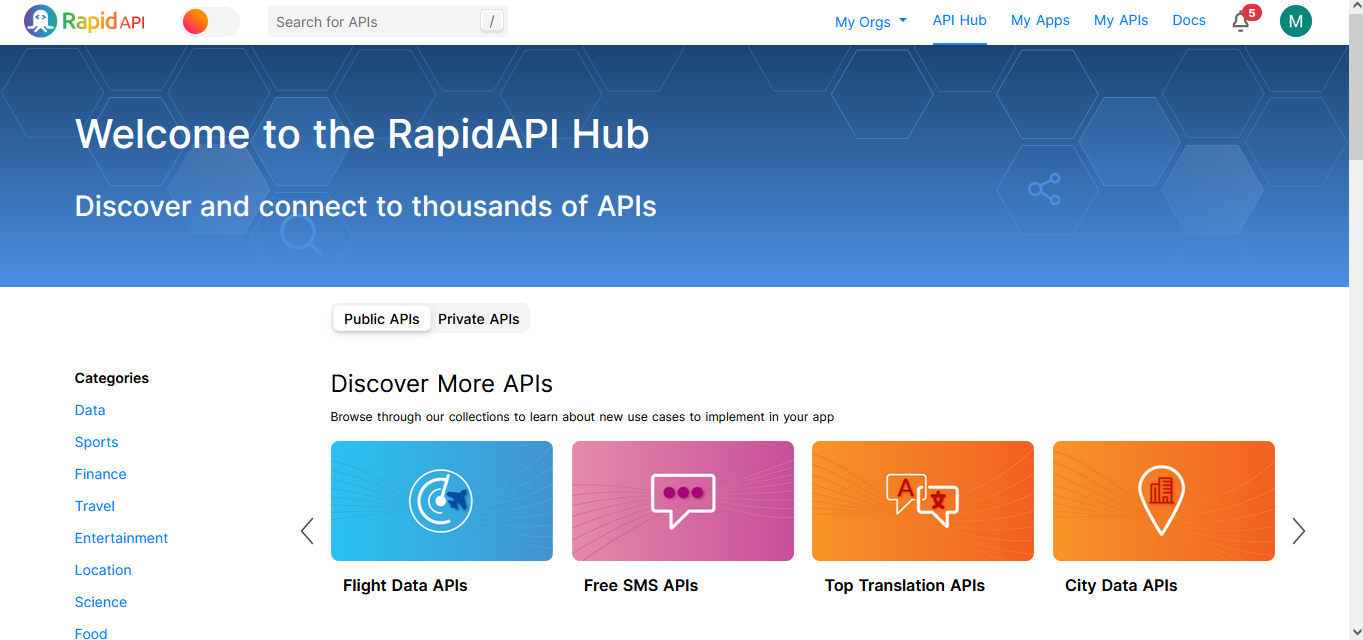

The API of choice will be AeroDataBox API, where we can search airports by location.
The code we have to run (using the Python requests library again) looks like this: 

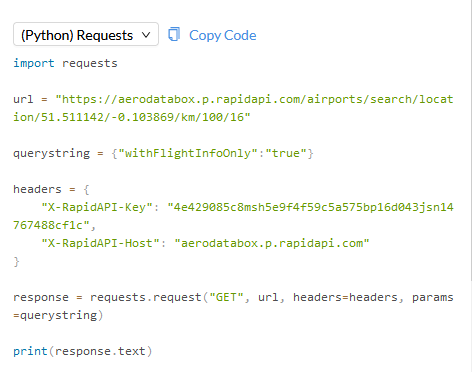

Looking closer at the url, it is of the form: 

"https://aerodatabox.p.rapidapi.com/airports/search/location/{latitude}/{longitude}/km/{radius}/{limit}"

Here we can tweak four parameters:
- The latitude and longitude: These values tell the API the exact point where it shall start searching. As mentioned earlier both numbers are of type float and can be negative.
- radius: The search radius in km.
- limit: The maximum number of airports that will be returned.

All we have to do is put in the geographical info we got from the city scraping. Let's take a look at the information that will be returned (after converting it into a dataframe):

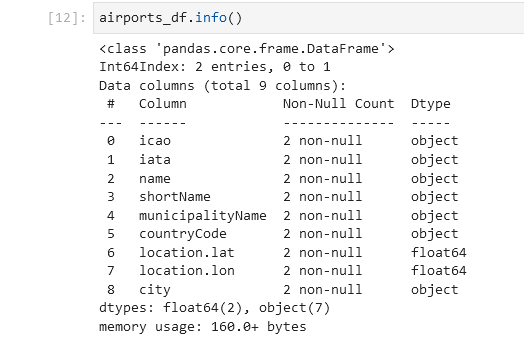

We decided to keep the following data:
 - the airport's name 
 - the city name
 - the icao: this is a unique international code. We will use it to collect the flights data.
 - latitude/longitude of the airport's position.
 
 We keep the lat/lon-data to measure the distance of the airport to the city. This gives Gans an idea how relevant the airports presence might be for the placing of the scooters.
 
Having the dataframes for the cities and the airports, we calculate the distance using the library geopy. As one can see in the code below, we keep the distance information in a separate dataframe:

In [ ]:
def city_airport_distance(cities_df : DataFrame, airports_df : DataFrame) -> DataFrame:
    from geopy.distance import distance as geodistance
                    
    keep_cols = ['city', 'icao', 'lat_airport', 'lon_airport', 'lat_city', 'lon_city']
    airport_distance = airports_df.merge(cities_df, on = 'city', suffixes=('_airport', '_city'))[keep_cols]
    airport_distance['distance_in_km'] = airport_distance.apply(
        lambda x: geodistance((x.lat_city, x.lon_city), (x.lat_airport, x.lon_airport)).km, axis=1)
    airport_distance.loc[:,'distance_in_km'] = airport_distance['distance_in_km'].round(2)
    return airport_distance[['city', 'icao', 'distance_in_km']]

## Gathering daily data

We only needed to collect the cities' info as well as the airports' info once. But data about the weather and the flights should be checked everyday to be up to date. 
Therefore we will make sure to write the code inside functions. This will make our life easier when automating the data pipeline via AWS.
As for the airports we will make use of APIs again, namely the openweather API and AeroDataBox again.

### Weather data / Flights data

As mentioned, openweather API will be the API of choice this time. It offers a 5 day weather forecast and we can make up to 1000 requests a day for free, which makes it the perfect candidate for our purpose.
The API even allows us to search by the city name!

The url is of the form:

api.openweathermap.org/data/2.5/forecast?q={city name}&appid={API key}

Our functions look like this:

In [ ]:
def scrape_weather(city_lst : list, openweather_key : str) -> DataFrame:
    weather_arguments = {
        'q' : '', #city
        'appid' : openweather_key, #api key
       # 'cnt' : '3', # number of results
        'units' : 'metric'
    }
    
    weather_lst = []
    for c in city_lst: 
        weather_arguments['q'] = c
        weather_json = get_weather(weather_arguments)

        keep_cols = ['city', 'dt_txt', 'main:temp', 'main:feels_like', 'main:humidity', 
                     'weather:0:description', 'visibility', 'wind:speed', 'wind:deg', 
                     'wind:gust', 'pop', 'rain:3h', 'snow:3h', 'sys:pod']
        weather_df = weather_json_to_df(weather_json, c, keep_cols)


        new_cols = ['city', 'date', 'temp_celcius', 'temp_feels_like_celcius', 'humidity_percent', 
                     'weather_description', 'visibility', 'wind_speed_meter_sec', 'wind_direction_degree', 
                     'wind_gust_meter_sec', 'pop_percent', 'rain_3h_mm', 'snow_3h_mm', 'pod']
        weather_df = weather_df.rename(columns=dict(zip(keep_cols, new_cols)))
        cleanup_weather(weather_df)
        weather_lst.append(weather_df)
    df = None
    if weather_lst:
        import pandas as pd
        df = pd.concat(weather_lst, ignore_index=True)
    return cleanup_weather(df)

def get_weather(weather_arguments : dict) -> dict:
    import requests
    import json
    #check that only string arguments are present
    if not all(isinstance(val, str) for val in weather_arguments.values()):
        raise Exception('all arguments must be string')
        
    #preparing the request url
    weather_api = "http://api.openweathermap.org/data/2.5/forecast?"
    api_arguments = repr(weather_arguments).replace("': '", '=').replace("', '", '&')[2:-2]
    weather_request = weather_api + api_arguments
    
    response = requests.get(weather_request)
    if response.status_code != 200:
        raise Exception(f'openweather returned code {response.status_code} for url = {weather_request}')
    return response.json()

def weather_json_to_df(weather_json : dict, city : str, keep_cols : list=None) -> DataFrame:
    # install flatdict; needed for weather_json_to_df()
    #install_pip_pkg({'flatdict'})
    
    from flatdict import FlatterDict as flatten
    from pandas import json_normalize as pd_json_normalize
    
    #take weather data and city name
    weather_df = pd_json_normalize([dict(flatten(i)) for i in weather_json['list']])
    weather_df = weather_df.assign(city = [city]*weather_df.shape[0])
    
    # return only selection of columns
    if not keep_cols:
        return weather_df
    keep_cols = [c for c in keep_cols if c in weather_df.columns]
    return weather_df[keep_cols]

def cleanup_weather(df : DataFrame):
    import pandas as pd
    if 'rain_3h_mm' in df:
        df.loc[:, 'rain_3h_mm'] = df['rain_3h_mm'].fillna(0)
    if 'snow_3h_mm' in df:
        df.loc[:, 'snow_3h_mm'] = df['snow_3h_mm'].fillna(0)
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    return df

As one can see, we split the different steps into smaller functions:
   - Get the weather information with the url (using the requests library again)
   - Transform the returned request into a dataframe
   - Clean the data: This step consists of adding some columns for consistency (not every request have             rain/snow_3h_mm info) and converting the dtype of the date to datetime
   - Finally going though the city list and make use of all these functions above.
   

We get the flights data in a similar fashion:

In [ ]:
def flights_scraping_tomorrow(icao_list):
    today = dt.datetime.now().astimezone(timezone('Europe/Berlin')).date()
    tomorrow = (today + dt.timedelta(days=1)).strftime('%Y-%m-%d') #format YYYY-MM-DD is used in the url for the aerodatabox
    list_for_flights_df = []
    times = [['00:00', '11:59'],['12:00', '23:59']]
    querystring = {"withLeg":"true","direction":"Arrival"}
    headers = {
        "X-RapidAPI-Key": api_key_dict['aerodatabox_key'],
        "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
    }
    for icao in icao_list:
        for time in times:
            url = f"https://aerodatabox.p.rapidapi.com/flights/airports/icao/{icao}/{tomorrow}T{time[0]}/{tomorrow}T{time[1]}"
            response = requests.request("GET", url, headers=headers, params=querystring)
            flights_json = response.json()
            for flight in flights_json['arrivals']:
                flights_dict = {}
                flights_dict['arrival_icao'] = icao
                flights_dict['arrival_time_local'] = flight['arrival'].get('scheduledTimeLocal', None)
                flights_dict['departure_city'] = flight['departure']['airport'].get('name', None)
                flights_dict['departure_icao'] = flight['departure']['airport'].get('icao', None)
                flights_dict['departure_time_local'] = flight['departure'].get('scheduledTimeLocal', None)
                flights_dict['airline'] = flight['airline'].get('name', None)
                flights_dict['flight_number'] = flight.get('number', None)
                flights_dict['data_retrieved_on'] = dt.datetime.now().astimezone(timezone('Europe/Berlin')).date()
                list_for_flights_df.append(flights_dict)
    flights_df = pd.DataFrame(list_for_flights_df)
    flights_df['timezone'] = 'UTC+' + flights_df['arrival_time_local'].str.split('+')[0][1].split(':')[0]
    flights_df['arrival_time_local'] = flights_df['arrival_time_local'].str.split('+')[0][0]
    cols = ['arrival_icao', 'arrival_time_local', 'timezone', 'departure_icao', 'departure_city', 'airline', 'flight_number', 'data_retrieved_on']
    flights_df = flights_df[cols]
    return flights_df

Once again we are using rapidAPI to get the data. Note that this time we make use of the unique icao of each airport.

## Setting up the database with AWS

Following the steps in AWS' section RDS we create an instance in MySQL, which is connected to the cloud.
To make sure that no tables are missing and the tables are connected using primary and foreign keys, we create the tables and set up the connections manually. Here you can see the cities' table as an example:

In [ ]:
###   CREATE TABLES
################################
cities_primary = 'city_id'
cities_cols = [cities_primary]
cities_cols.extend(cities_df.columns)
cities_dict = {'cities': (cities_cols, 
                    [f'int NOT NULL AUTO_INCREMENT, PRIMARY KEY ({cities_primary})', #city_id
                    'varchar(255) NOT NULL',       #city 
                    'varchar(255)',                #member_state
                    'int',                         #officialpopulation
                    'DATETIME',                    #date
                    'DECIMAL(6, 4)',               #lat
                    'DECIMAL(6, 4)']) }            #lon

Let's have a look at our raltional database system:

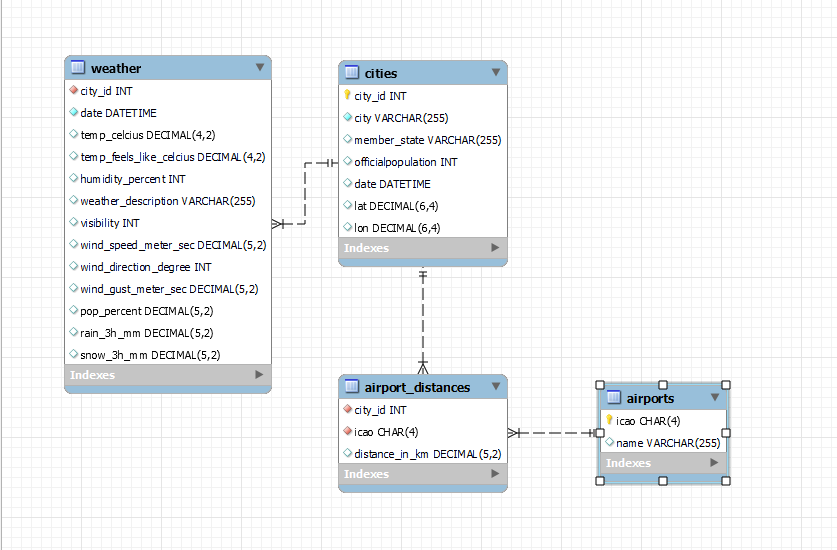

The tables weather, cities and airport_distances are connected via the unique city_id that we created in the above code. Furthermore the airports' table is connected to the distances via the icao.

## Connecting to our database and populate the tables

To connect Python with our SQL database we will use the library SQLalchemy. The connection to our RDS is established using the hostname that was assigned during it's creation:

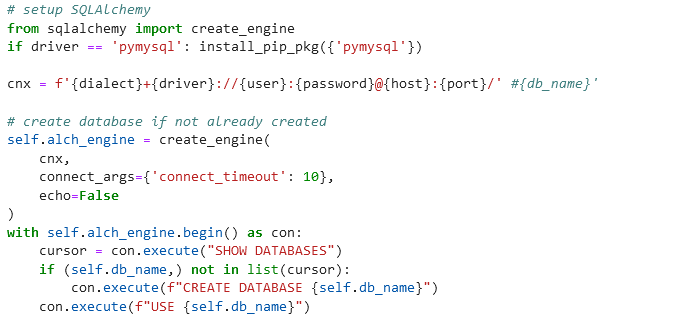

The following code allows us to populate the tables we created:

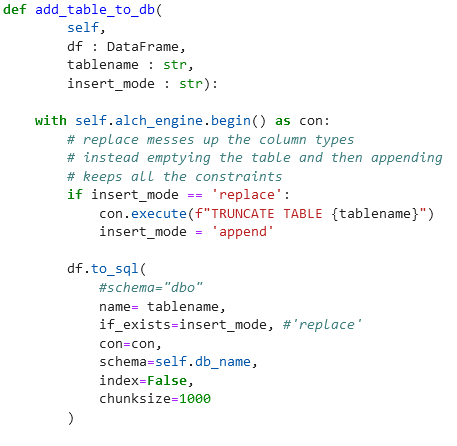

These functions (and more) are defined in a class called MyMySQLConnection.



Before we make use of AWS Lambda let's have a quick look at each table to see what we achieved so far:

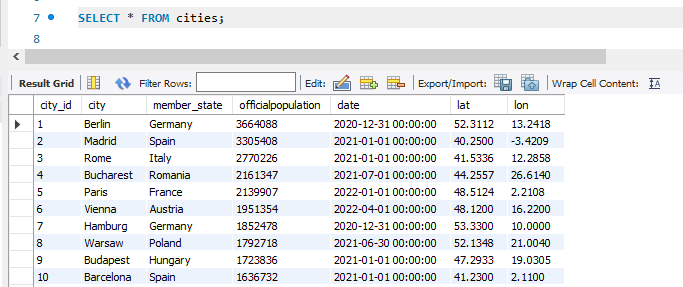

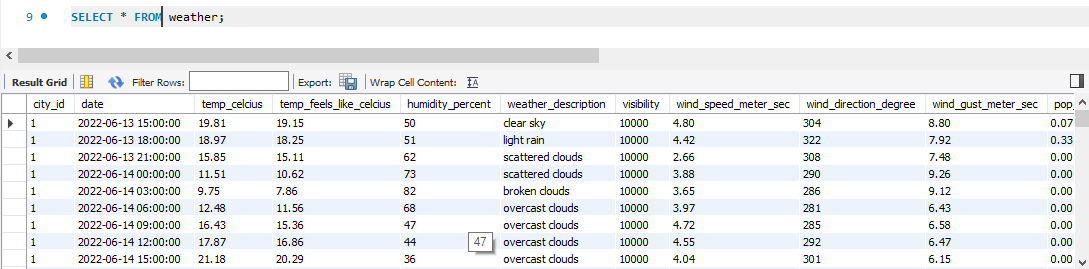

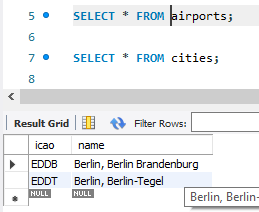

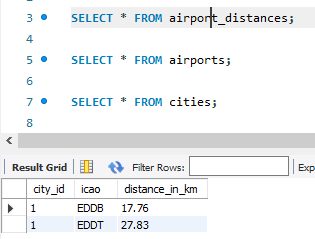

This is all looking good so far. But there is still one thing we want to get rid of: Up until now we had to do the data scraping manually. If we wanted to get the weather or flights data, we had to run the code by ourselves. To avoid that we make use of AWS Lamdba!

## Creating functions in AWS Lambda

In this explanation we will only implement the weather function. The main reason for that being the limited amount of requests per month we had for a free subscription of the AeroDataBox API.
First search in the AWS services for Lambda and create a new function. After you finished you should be able to see a code source interface. Here you already see an example code with a function called lambda handler. The function's name in the code always has to be lambda handler! Probably after a few adjustments to your code you wrote earlier  you can copy it in there. Don't forget to import the libraries necessary to run the code!

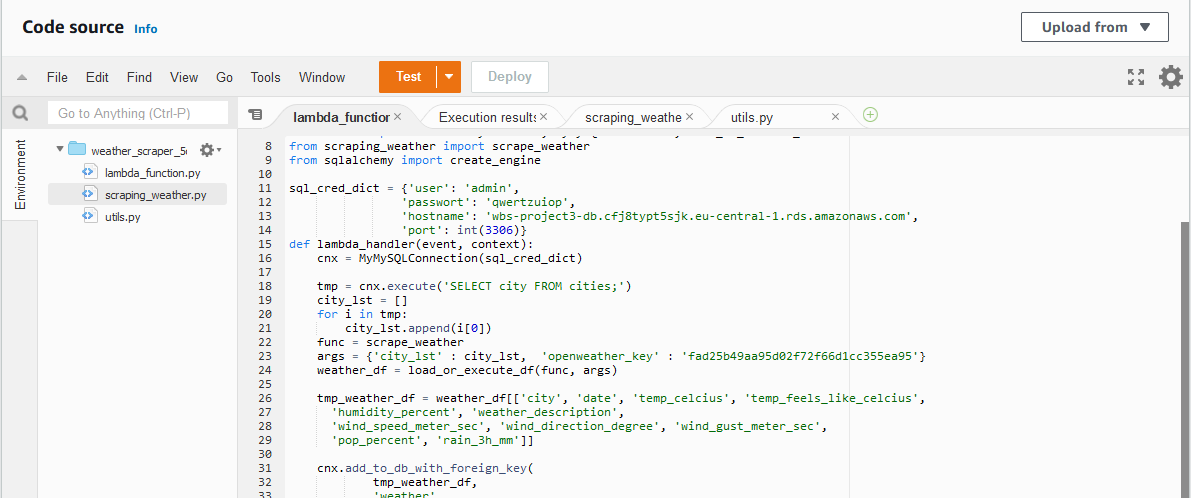

### Adding layers 

When testing the code for the first time you will probably get an error message.
Unfortunately AWS has not every Python library available by default. To get your code working nonetheless you can add layers to your Lamdba function.

There are three ways to add layers to your function:

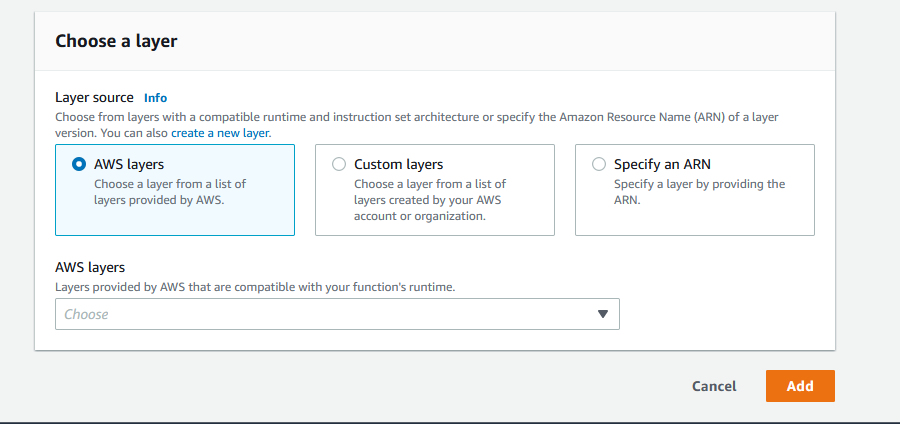

- The AWS layers consist of some basic libraries like pandas.
- Specify an ARN: ARN stands for Amazon Resource Name. A list of many libraries and their respective ARNs can be found here: https://github.com/keithrozario/Klayers/tree/master/deployments/python3.8/arns
- Custom layers: If you can not find an ARN that fits your needs, you may have to add custom layers. You do this by pip installing the libraries you need into a folder in your local directory and uploading that folder as a zip file. 

For our weather data we made use of all three options.
Also we created some more .py-files in our definition of our lambda function as can be seen on the left side of the screenshot:

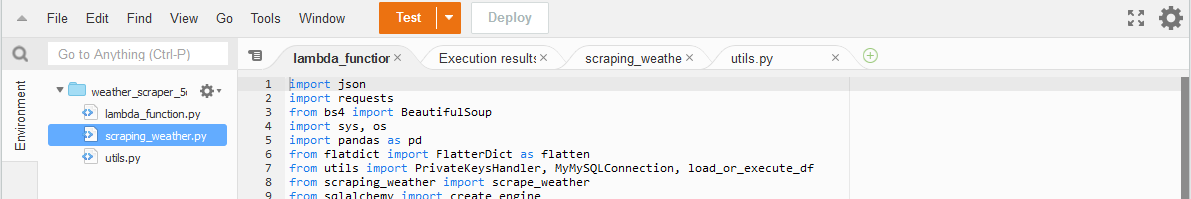

We did this because we split our project into a main file and several supporting files (where most of the functions are defined). As you can see these files can be implemented nicely into the structure of the lambda function by simply importing them at the beginning of the code.

If the testing was succesful, we only need one more step for automating our pipeline: We have to set a trigger that fires everyday. Without that out function won't run by itself.

## Setting the trigger

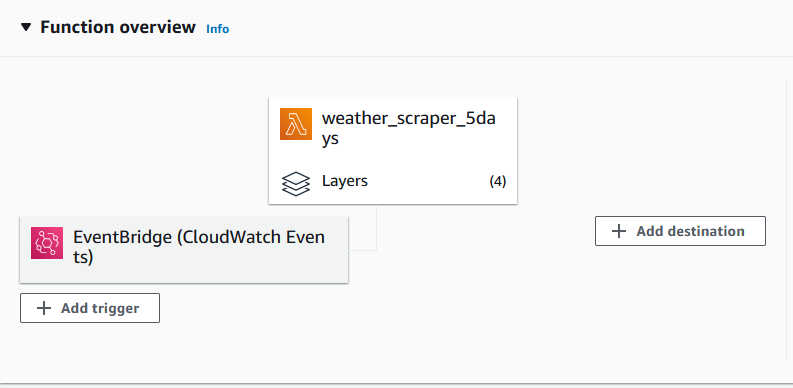

In the lower left side of our function triggers can be added. We decided to let a CloudWatch Event to be the trigger, though there are many other possible options to set those.
We can give it a name and a description and, of course, set the rules for firing the trigger:

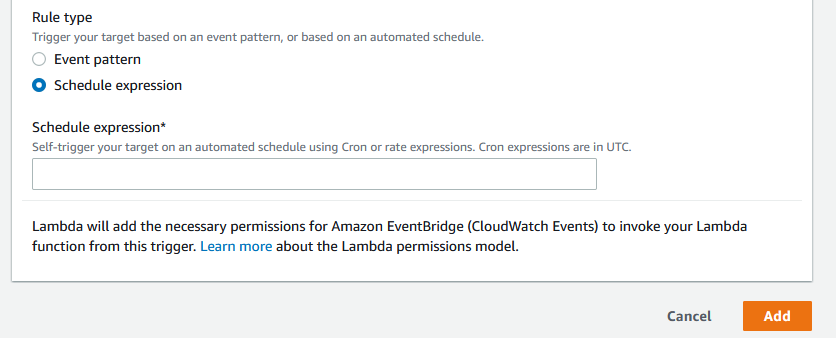

Note that in this case the expresseion has to be a cron-expression. An easy generator for said expressions can be found following this link:

https://www.freeformatter.com/cron-expression-generator-quartz.html

As an example: For the trigger firing everyday at 6am, we would write cron(0 0 6 * * ?).

After a while (depending on the trigger rate) we can monitor if and when our trigger has fired:

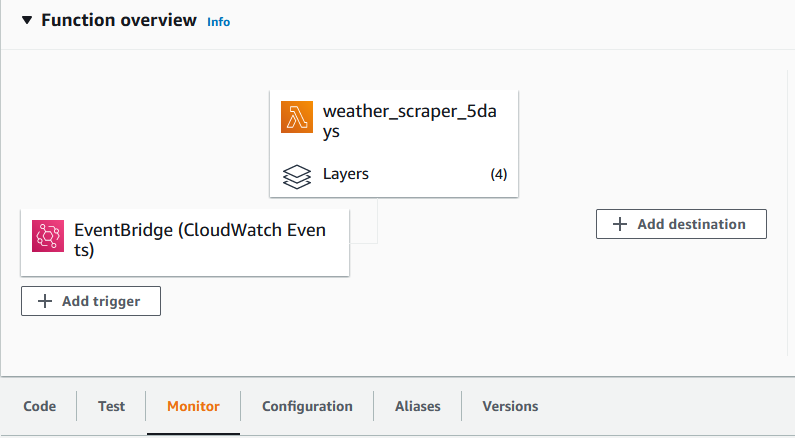

You can find the invocation count, duration time, success rate and other interesting data there.

This concludes the pipeline report. One last thing to note: In the above code used for the the lambda function, I put the API, the hostname etc. there directly. If you share your function, you should definitely consider using environmental variables or further encryption to keep your secrets safe!